In [170]:
import uproot
import pandas

In [171]:
def prepareDataset(dataset, chan):
    df = dataset[chan]["ntuple"].pandas.df(["jetPt", "nJets", "jetEta", "Mass", "MTWZ", "mjj", "Eta", "MET", "jetPhi"], flatten=False)
    filtered_df = df[(df["nJets"] > 2.) & (df["mjj"] > 100.)].copy()
    filtered_df["ptj1"] = filtered_df["jetPt"].str[0]
    filtered_df["ptj2"] = filtered_df["jetPt"].str[1]
    filtered_df["phij1"] = filtered_df["jetPhi"].str[0]
    filtered_df["phij2"] = filtered_df["jetPhi"].str[1]
    filtered_df["etaj1"] = filtered_df["jetEta"].str[0]
    filtered_df["etaj2"] = filtered_df["jetEta"].str[2]
    filtered_df["dEtajj"] = filtered_df["etaj1"] - filtered_df["etaj2"]
    filtered_df["dPhijj"] = filtered_df["phij1"] - filtered_df["phij2"]
    filtered_df["etas3l"] = filtered_df["Eta"] - 0.5*(filtered_df["etaj1"] + filtered_df["etaj2"])
    filtered_df["zep3l"] = filtered_df["etas3l"]/filtered_df["dEtajj"]
    filtered_df = filtered_df.drop(["jetEta", "jetPt", "jetPhi"], axis=1)
    return filtered_df

In [296]:
def eventsProcessed(dataset):
    df = dataset["metaInfo"]["metaInfo"].pandas.df()
    return sum(test["summedWeights"])

In [172]:
qcdwz_file = uproot.open("Data/2018-04-29-wz3lnu-powheg-WZxsec2016-3MediumLeptonsNoVetoToWselection-v1/combined.root")
ewwz_file = uproot.open("Data/2018-04-29-wlljj-ewk-WZxsec2016-3MediumLeptonsNoVetoToWselection-v1/combined.root")
ew_df = pandas.DataFrame()
qcd_df = pandas.DataFrame()
for chan in ["eee", "eem", "emm", "mmm"]:
    ew_df = pandas.concat([ew_df, prepareDataset(ewwz_file, chan)])
    qcd_df = pandas.concat([qcd_df, prepareDataset(qcdwz_file, chan)])

In [173]:
ew_df = ew_df.drop(["Mass", "MtToMET", "type1_pfMETEt", "nJets", "Eta"], axis=1)
qcd_df = qcd_df.drop(["Mass", "MtToMET", "type1_pfMETEt", "nJets", "Eta"], axis=1)

In [174]:
qcd_df["isSignal"] = -1
qcd_df

,mjj,ptj1,ptj2,phij1,phij2,etaj1,etaj2,dEtajj,dPhijj,etas3l,zep3l,isSignal
entry,,,,,,,,,,,,
21,166.633636,59.698605,36.747917,-2.092060,0.094505,1.257995,-0.563818,1.821812,-2.186565,2.267637,1.244715,-1
35,1854.938965,130.573730,111.357719,-3.101528,2.852166,-3.381214,-2.990310,-0.390904,-5.953694,3.773465,-9.653166,-1
53,315.263184,54.327881,43.691971,-0.320979,2.111929,-0.873281,3.767506,-4.640787,-2.432908,-2.797795,0.602871,-1
88,163.252640,67.532608,54.199623,-2.947604,-1.331949,-3.083182,-3.464014,0.380832,-1.615655,0.975853,2.562423,-1
103,172.384109,341.436279,114.336067,0.810718,-0.001436,0.392344,0.034664,0.357680,0.812154,0.891461,2.492344,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
184306,587.116943,332.928955,75.649826,-3.034289,-1.292649,-0.385930,2.655473,-3.041403,-1.741639,-0.190683,0.062696,-1
184311,238.527557,178.710266,63.587006,1.895231,0.083600,0.366809,0.153344,0.213465,1.811631,-0.600420,-2.812736,-1
184343,396.767975,143.450394,33.921539,0.267259,2.624281,-0.282596,-0.271888,-0.010708,-2.357022,1.648392,-153.942723,-1


In [175]:
ew_df["isSignal"] = 1
ew_df

,mjj,ptj1,ptj2,phij1,phij2,etaj1,etaj2,dEtajj,dPhijj,etas3l,zep3l,isSignal
entry,,,,,,,,,,,,
1,744.512634,244.329880,70.080750,-0.952728,1.927766,0.964082,-2.973454,3.937536,-2.880494,0.700316,0.177856,1
2,1094.974487,116.069794,36.278889,2.033741,-0.081956,3.470814,-1.905841,5.376655,2.115696,1.489173,0.276970,1
3,566.254272,362.949463,43.012203,1.237676,2.603570,-2.759324,-2.112763,-0.646561,-1.365894,3.242719,-5.015330,1
7,191.022415,165.128555,86.995255,0.384944,-0.406747,0.404612,2.614320,-2.209708,0.791692,-1.344288,0.608355,1
9,1562.951172,200.326126,73.051765,-2.485390,0.013941,-1.633043,-1.531901,-0.101142,-2.499332,4.974371,-49.182023,1
...,...,...,...,...,...,...,...,...,...,...,...,...
38927,779.578979,96.872704,84.472717,0.036417,0.462916,1.022518,-1.729396,2.751914,-0.426500,-0.489648,-0.177930,1
38931,665.170044,492.240631,148.574539,2.771630,0.224134,-0.191494,0.933685,-1.125179,2.547495,-0.719631,0.639570,1
38932,549.855103,397.701080,94.984352,0.455766,-3.040766,-0.545479,1.318593,-1.864072,3.496532,-1.098707,0.589412,1


In [176]:
full_df = pandas.concat([ew_df, qcd_df], sort=False)
truth_df = full_df["isSignal"]
train_full_df = full_df.drop(["isSignal"], axis=1)
full_df

,mjj,ptj1,ptj2,phij1,phij2,etaj1,etaj2,dEtajj,dPhijj,etas3l,zep3l,isSignal
entry,,,,,,,,,,,,
1,744.512634,244.329880,70.080750,-0.952728,1.927766,0.964082,-2.973454,3.937536,-2.880494,0.700316,0.177856,1
2,1094.974487,116.069794,36.278889,2.033741,-0.081956,3.470814,-1.905841,5.376655,2.115696,1.489173,0.276970,1
3,566.254272,362.949463,43.012203,1.237676,2.603570,-2.759324,-2.112763,-0.646561,-1.365894,3.242719,-5.015330,1
7,191.022415,165.128555,86.995255,0.384944,-0.406747,0.404612,2.614320,-2.209708,0.791692,-1.344288,0.608355,1
9,1562.951172,200.326126,73.051765,-2.485390,0.013941,-1.633043,-1.531901,-0.101142,-2.499332,4.974371,-49.182023,1
...,...,...,...,...,...,...,...,...,...,...,...,...
184306,587.116943,332.928955,75.649826,-3.034289,-1.292649,-0.385930,2.655473,-3.041403,-1.741639,-0.190683,0.062696,-1
184311,238.527557,178.710266,63.587006,1.895231,0.083600,0.366809,0.153344,0.213465,1.811631,-0.600420,-2.812736,-1
184343,396.767975,143.450394,33.921539,0.267259,2.624281,-0.282596,-0.271888,-0.010708,-2.357022,1.648392,-153.942723,-1


In [177]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(full_df, truth_df, test_size=0.33, random_state=42)
X_test_ew = X_test[X_test["isSignal"] < 0]
X_test_qcd = X_test[X_test["isSignal"] > 0]
X_train = X_train.drop(["isSignal"], axis=1)
X_test = X_test.drop(["isSignal"], axis=1)
X_test_qcd = X_test_qcd.drop(["isSignal"], axis=1)
X_test_ew = X_test_ew.drop(["isSignal"], axis=1)

In [178]:
import xgboost as xgb

,mjj,ptj1,ptj2,phij1,phij2,etaj1,etaj2,dEtajj,dPhijj,etas3l,zep3l
entry,,,,,,,,,,,
1956,369.930267,274.933533,245.859390,-2.018961,-1.153596,-1.552221,0.845518,-2.397738,-0.865365,0.007252,-0.003024
16420,1619.508423,530.581055,211.206116,-1.667776,-2.422265,-1.043562,2.893902,-3.937464,0.754489,0.150207,-0.038148
13988,230.545197,89.523521,69.918022,0.484928,-2.223410,2.584542,3.318141,-0.733600,2.708339,-1.485883,2.025468
16062,2751.347412,596.682495,389.501404,0.890758,-1.960885,1.472539,-1.598294,3.070833,2.851643,-0.783240,-0.255058
37589,3315.580078,283.880951,184.758148,-0.962210,1.679076,-2.136457,-0.514513,-1.621943,-2.641286,0.066472,-0.040983
...,...,...,...,...,...,...,...,...,...,...,...
7719,906.568237,206.050537,119.012810,-0.554640,-3.082787,-2.503668,-0.210203,-2.293465,2.528147,2.283563,-0.995683
32112,1339.464478,365.374298,229.836914,-0.306225,-1.554461,-1.161640,-1.867742,0.706102,1.248236,2.642297,3.742091
17114,960.510559,344.379059,158.509491,-0.097564,1.787216,0.597945,-1.977224,2.575169,-1.884780,1.390014,0.539776


In [179]:
mod = xgb.XGBRegressor(
    gamma=1,                 
    learning_rate=0.01,
    max_depth=3,
    n_estimators=10000,                                                                    
    subsample=0.8,
    random_state=34
)

In [180]:
mod.fit(X_train, y_train)

[11:06:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=34,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [181]:
predictions_qcd = mod.predict(X_test_ew)
predictions_ew = mod.predict(X_test_qcd)

In [260]:
predictions = mod.predict(X_test)

In [183]:
import matplotlib.pyplot as plt

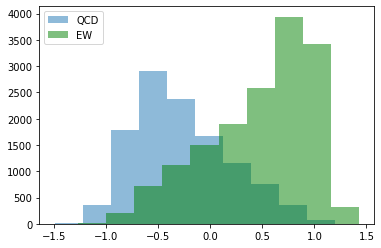

In [187]:
plt.hist(predictions_qcd,alpha=0.5, label='QCD')
plt.hist(predictions_ew,color='g', alpha=0.5,label='EW')
plt.legend()

In [265]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import numpy

In [313]:
cutoff = 0.9
cat_predict = [1 if x > cutoff else -1 for x in predictions] 
print("Roc score is", roc_auc_score(cat_predict, y_test))

Roc score is 0.7290949729160247


In [314]:
print(confusion_matrix(cat_predict, y_test))
print(accuracy_score(cat_predict, y_test))

[[11341 12200]
 [   85  3522]]
0.5474804773832327


In [315]:
print("Rate of acceptance")
acc_rate_sig = len([x for x in filter(lambda x: x > cutoff, predictions_ew)])/eventsProcessed(ewwz_file)
acc_rate_bkgd = len([x for x in filter(lambda x: x > cutoff, predictions_qcd)])/eventsProcessed(qcdwz_file)
#acc_bkgd = testqcd_emm_wtruth[testqcd_emm_wtruth["prediction"] > 0.9]
print("Signal", acc_rate_sig)
print("Background", acc_rate_bkgd)

Rate of acceptance
Signal 0.003522
Background 8.5e-05


In [316]:
print("Scaled by cross section and 36 fb-1")
print("Signal", acc_rate_sig*17.5*36)
print("Background", acc_rate_bkgd*4.43*1000*36)

Scaled by cross section and 36 fb-1
Signal 2.2188600000000003
Background 13.5558


1000000.0